# Import the dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [0]:
#links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
#tags = pd.read_csv('tags.csv')

In [3]:
movies.shape

(9742, 3)

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.shape

(100836, 4)

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings.groupby(['movieId']).size().reset_index().sort_values(by='movieId', ascending=True)

,movieId,0
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9719,193581,1
9720,193583,1
9721,193585,1
9722,193587,1


In [0]:
ratings['userId'] = ratings['userId'].astype('str')
ratings['movieId'] = ratings['movieId'].astype('str')
movies['movieId'] = movies['movieId'].astype('str')

# Statistics of the dataset

In [9]:
userId = ratings.userId.unique()
movieId = ratings.movieId.unique()
num_users = len(userId)
num_items =len(movieId)
print('number of unique users:', num_users)
print('number of unique movies:', num_items)

number of unique users: 610
number of unique movies: 9724


In [10]:
sparsity = 1 - len(ratings) / (num_users * num_items)
print('matrix sparsity:',sparsity)

matrix sparsity: 0.9830003169443864


In [11]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

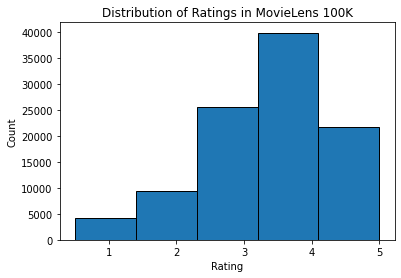

In [12]:
plt.hist(ratings['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()
# it appears to be a normal distribution with most ratings centered at 3-4

In [0]:
#Number of movies rated by each user.
numMoviesRatedByUser = ratings.groupby(['userId']).size().reset_index()

In [0]:
numMoviesRatedByUser = numMoviesRatedByUser.sort_values(by=0, ascending=True)

In [15]:
numMoviesRatedByUser.tail()

,userId,0
194,274,1346
387,448,1864
416,474,2108
554,599,2478
350,414,2698


In [16]:
print('Average number of movies rated by a user:',numMoviesRatedByUser[0].mean(axis = 0))
print('Median of movies rated by a user:',numMoviesRatedByUser[0].median(axis = 0))
print('Minimum number of movies rated by a user: 20')
print('Maximum number of movies rated by a user: 2698')

Average number of movies rated by a user: 165.30491803278687
Median of movies rated by a user: 70.5
Minimum number of movies rated by a user: 20
Maximum number of movies rated by a user: 2698


In [17]:
numMoviesRatedByUser.loc[numMoviesRatedByUser[0]==71]

,userId,0
49,143,71


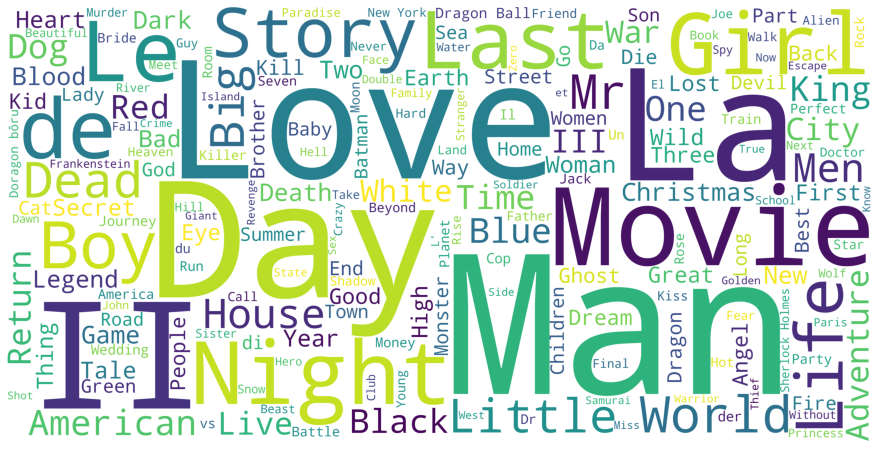

In [18]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [19]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

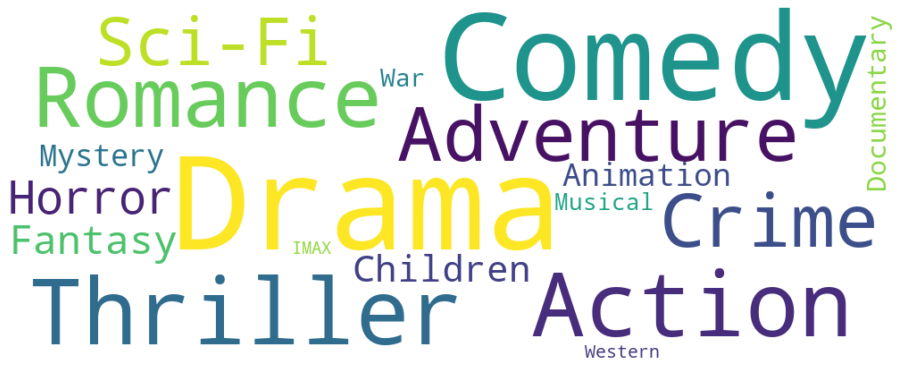

In [20]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#Train test split (Random Split)

In [0]:
def train_test_split(data, test_ratio):
  train_index = []
  test_index = []
  for x in np.random.uniform(0,1,len(data)) < 1 - test_ratio:
    train_index.append(x)
    test_index.append(not x)
  return data[train_index], data[test_index]

In [0]:
train, test = train_test_split(ratings, 0.2)

In [23]:
print('Training Shape', train.shape)
print('Test Shape', test.shape)

Training Shape (80557, 4)
Test Shape (20279, 4)


# Matrix

In [0]:
def createMatrix(data):
    R = data.pivot(index='userId', columns = 'movieId', values = 'rating').fillna(np.nan)
    
    users = R.index
    users_index = {users[i]: i for i in range(len(users))}

    itemcols = list(R.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    # users_index gives us a mapping of user_id to index of user
    # items_index provides the same for items
    return R, users_index, items_index


# Matrix Factorization using SVD

In [0]:
from scipy.sparse.linalg import  svds
from scipy.linalg import sqrtm

def svd(R, k):
  #convert the R matrix to numpy array
  RMat = np.array(R)
  # the nan or unavailable entries are masked
  mask = np.isnan(RMat)
  masked_arr = np.ma.masked_array(RMat, mask)

  # get the mean of the columns. 
  item_means = np.mean(masked_arr, axis=0)
  # nan entries will replaced by the average rating for each item
  RMat = masked_arr.filled(item_means)

  '''
  x is a df with 610 rows and 9397 coluumn. The values in the df x is the average rating.
  Example:
  3 4 5 6
  3 4 5 6
  3 4 5 6
  '''
  x = np.tile(item_means, (RMat.shape[0],1))

  # we remove the per item average from all entries.
  # the above mentioned nan entries will be essentially zero now
  RMat = RMat - x
  # perform SVD
  U, s, V = svds(RMat, k = k)
  #sigma returned from svds is a array with the diagonal values
  #converting the array into a diagonal matrix (matrix having value only in diagonal, rest values are zero)
  s = np.diag(s)

  s_root=sqrtm(s)
  Usk=np.dot(U,s_root)
  skV=np.dot(s_root,V)
  UsV = np.dot(Usk, skV)
  UsV = UsV + x
  print("svd done with K:", k)
  return UsV

#Model Evaluation

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [0]:
train_t, train_v = train_test_split(train, 0.2)

In [28]:
print('Training Shape', train_t.shape)
print('Test Shape', train_v.shape)

Training Shape (64687, 4)
Test Shape (15870, 4)


In [0]:
R, users_index, items_index = createMatrix(train_t)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7689: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


Text(0.5, 1.05, 'Sparse Matrix representing the movie ratings by users')

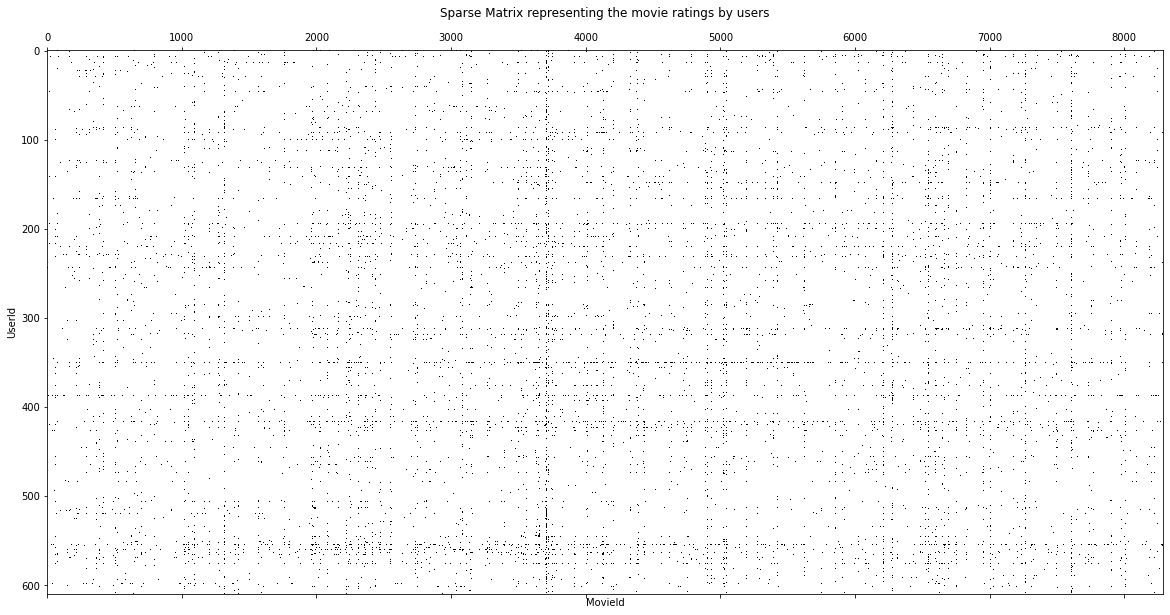

In [30]:
plt.figure(figsize=(20,10))
plt.spy(R, aspect='auto')
plt.xlabel('MovieId')
plt.ylabel('UserId')
plt.title('Sparse Matrix representing the movie ratings by users')

In [31]:
# to test the performance over a different number of features
no_of_features = [5,15,20,23,25,30,35,40,45,50]

for f in no_of_features:
  svdout = svd(R, k=f)
  pred = [] #to store the predicted ratings
  #count = 0
  for i,row in train_v.iterrows():
    user = row['userId']
    item = row['movieId']
    u_index = users_index[user]
    if item in items_index:
      i_index = items_index[item]
      pred_rating = svdout[u_index, i_index]
      #count = count+1

    else:
      pred_rating = np.mean(svdout[u_index, :])
    pred.append(pred_rating)
  #print('Count', count)

  print('RMSE custom method:', mean_squared_error(train_v['rating'], pred))
  print('mean_absolute_error:', mean_absolute_error(train_v['rating'], pred))


svd done with K: 5
RMSE custom method: 0.9386073157353055
mean_absolute_error: 0.745241478524331
svd done with K: 15
RMSE custom method: 0.9363069471449657
mean_absolute_error: 0.744082279964499
svd done with K: 20
RMSE custom method: 0.9361489792247166
mean_absolute_error: 0.7447818451062028
svd done with K: 23
RMSE custom method: 0.9363802567144855
mean_absolute_error: 0.7444284504774291
svd done with K: 25
RMSE custom method: 0.936555923942472
mean_absolute_error: 0.744103035645708
svd done with K: 30
RMSE custom method: 0.9393648078413877
mean_absolute_error: 0.7455826645513415
svd done with K: 35
RMSE custom method: 0.9385070446785801
mean_absolute_error: 0.744897673786879
svd done with K: 40
RMSE custom method: 0.9405434273113987
mean_absolute_error: 0.7452824248374155
svd done with K: 45
RMSE custom method: 0.9410183998153605
mean_absolute_error: 0.7450020911632464
svd done with K: 50
RMSE custom method: 0.9424334782557977
mean_absolute_error: 0.7458882559791644


# Prediction

In [0]:
R, users_index, items_index = createMatrix(train)

In [33]:
svdout_final = svd(R, k=23)

svd done with K: 23


In [0]:
allUsers = test.userId.unique()
allMovies = test.movieId.unique()

In [0]:
test = test.drop(axis=1, labels='timestamp')

In [0]:
testPred = pd.pivot(data=test, index='userId', columns='movieId', values='rating')

In [37]:
testPred.head(10)

movieId,1,10,100,100159,100277,1003,100306,100383,100390,100498,1005,100527,1006,1007,100714,1008,100843,100882,1009,101,1010,101025,1011,101112,101142,1012,1013,101362,1014,101415,1015,101525,101531,101577,1016,101612,1017,101741,101864,1019,...,97785,97836,97860,97866,97913,97921,97923,97938,98122,98124,98154,98243,98279,98491,98499,98585,986,98604,98623,987,98809,98961,99,990,99007,991,99106,99112,99114,99117,99145,99149,99191,994,99532,996,99813,999,99910,99917
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for user in allUsers:
  pred=[]
  for movie in allMovies:
    u_index = users_index[user]
    if movie in items_index:
      i_index = items_index[movie]
      pred_rating = svdout_final[u_index, i_index]
    else:
      pred_rating = np.mean(svdout_final[u_index, :])
    pred.append(pred_rating)
  testPred.loc[(user)] = pred

In [39]:
testPred.head(10)

movieId,1,10,100,100159,100277,1003,100306,100383,100390,100498,1005,100527,1006,1007,100714,1008,100843,100882,1009,101,1010,101025,1011,101112,101142,1012,1013,101362,1014,101415,1015,101525,101531,101577,1016,101612,1017,101741,101864,1019,...,97785,97836,97860,97866,97913,97921,97923,97938,98122,98124,98154,98243,98279,98491,98499,98585,986,98604,98623,987,98809,98961,99,990,99007,991,99106,99112,99114,99117,99145,99149,99191,994,99532,996,99813,999,99910,99917
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.113836,4.553772,3.530522,4.732323,3.984573,3.054034,3.629358,2.650937,3.476393,3.221017,3.743923,4.388767,4.117132,4.515541,4.552847,4.513009,3.747001,3.308498,2.0,3.432681,3.120462,3.605926,3.724094,3.955653,2.163390,3.486753,1.957920,3.509542,3.652986,4.403065,3.703754,3.518743,2.859470,2.017968,4.040954,3.458529,3.626381,3.105275,3.648524,3.543389,...,2.513815,3.279258,3.279258,3.5,3.732769,2.467414,3.5,3.279258,3.017416,4.0,2.0,1.5,3.021908,3.279258,3.0,3.0,3.279258,3.377400,4.0,3.279258,3.279258,3.279258,3.279258,3.279258,3.279258,3.279258,3.279258,3.279258,3.279258,2.002473,4.5,3.279258,3.279258,3.548515,3.279258,3.279258,3.279258,2.5,3.279258,3.279258
10,3.847319,3.770966,3.378980,3.960399,3.936929,3.067541,3.520331,2.640889,3.264108,3.214887,3.536790,4.123521,4.017991,4.043788,4.150102,4.065886,3.629920,3.176687,2.0,3.407051,3.208003,3.524343,3.559801,3.819630,2.105129,3.518603,1.905797,3.404118,3.472988,4.129410,3.634238,3.319534,2.854919,2.015580,3.602282,3.457085,3.440160,2.977907,3.437117,3.492579,...,2.499763,3.266411,3.266411,3.5,3.749900,2.343276,3.5,3.266411,3.025366,4.0,2.0,1.5,3.097991,3.266411,3.0,3.0,3.266411,3.376412,4.0,3.266411,3.266411,3.266411,3.266411,3.266411,3.266411,3.266411,3.266411,3.266411,3.266411,1.999601,4.5,3.266411,3.266411,3.510614,3.266411,3.266411,3.266411,2.5,3.266411,3.266411
100,3.897214,4.146924,3.392009,4.258209,3.915429,3.057559,3.564626,2.620760,3.272128,3.252106,3.562784,4.145109,3.956109,4.056247,4.158542,4.036575,3.589386,3.276430,2.0,3.403478,3.191184,3.618951,3.580646,3.833765,2.157747,3.501286,1.866947,3.481481,3.478410,4.422526,3.649558,3.350447,2.881535,2.006017,3.657610,3.483996,3.456504,2.996004,3.487014,3.504117,...,2.487537,3.270422,3.270422,3.5,3.766928,2.322154,3.5,3.270422,2.989229,4.0,2.0,1.5,3.092308,3.270422,3.0,3.0,3.270422,3.375720,4.0,3.270422,3.270422,3.270422,3.270422,3.270422,3.270422,3.270422,3.270422,3.270422,3.270422,1.999909,4.5,3.270422,3.270422,3.493670,3.270422,3.270422,3.270422,2.5,3.270422,3.270422
101,3.930286,4.037386,3.365994,4.169078,3.918768,3.059450,3.536661,2.620588,3.318080,3.238211,3.531415,4.112620,4.041159,4.137155,4.188660,4.043434,3.628684,3.322710,2.0,3.413446,3.145586,3.589769,3.546669,3.805645,2.104250,3.453986,1.880049,3.458246,3.429312,4.240611,3.657409,3.384236,2.879903,1.997370,3.709643,3.441570,3.510103,2.957006,3.455006,3.500898,...,2.497954,3.267808,3.267808,3.5,3.752987,2.341201,3.5,3.267808,3.003085,4.0,2.0,1.5,3.061725,3.267808,3.0,3.0,3.267808,3.374305,4.0,3.267808,3.267808,3.267808,3.267808,3.267808,3.267808,3.267808,3.267808,3.267808,3.267808,2.001733,4.5,3.267808,3.267808,3.501236,3.267808,3.267808,3.267808,2.5,3.267808,3.267808
102,3.911172,4.038209,3.383878,4.197372,3.908711,3.059028,3.528279,2.627204,3.333644,3.262002,3.528505,4.088053,4.002786,4.019813,4.151454,4.057316,3.597011,3.300245,2.0,3.418467,3.137796,3.602301,3.578257,3.793558,2.132431,3.427440,1.875382,3.400000,3.412967,4.191356,3.625756,3.381723,2.897231,1.999111,3.722285,3.441206,3.534608,2.922997,3.509985,3.503681,...,2.499174,3.267287,3.267287,3.5,3.752078,2.329375,3.5,3.267287,2.994565,4.0,2.0,1.5,3.066554,3.267287,3.0,3.0,3.267287,3.375040,4.0,3.267287,3.267287,3.267287,3.267287,3.267287,3.267287,3.267287,3.267287,3.267287,3.267287,2.002279,4.5,3.267287,3.267287,3.496238,3.267287,3.267287,3.267287,2.5,3.267287,3.267287
103,3.953996,4.259532,3.546636,4.350434,3.942739,3.063863,3.615099,2.669213,3.42

In [0]:
def unpivot(frame):
    N, K = frame.shape
    data = {'rating': frame.to_numpy().ravel('F'),
            'movieId': np.asarray(frame.columns).repeat(N),
            'userId': np.tile(np.asarray(frame.index), K)}
    return pd.DataFrame(data, columns=['userId', 'movieId', 'rating'])

testPred_unpivoted= unpivot(testPred)

In [41]:
testPred_unpivoted.shape

(3113817, 3)

In [0]:
final_results = pd.merge(test, testPred_unpivoted,  how='left', left_on=['userId','movieId'], right_on = ['userId','movieId'])

In [0]:
final_results = final_results.merge(movies, how='left', on='movieId')

In [0]:
final_results = final_results.rename(columns={"rating_x": "rating", "rating_y": "ratingPred"})
   

In [0]:
final_results['roundedRating']=''

for i, row in final_results.iterrows():
  if(row['ratingPred'] <=0.5):
    final_results.loc[i, 'roundedRating'] = 0.5
  elif(row['ratingPred'] > 0.5 and row['ratingPred'] <=1.0 ):
    final_results.loc[i, 'roundedRating'] = 1.0
  elif(row['ratingPred'] > 1.0 and row['ratingPred'] <=1.5 ):
    final_results.loc[i, 'roundedRating'] = 1.5
  elif(row['ratingPred'] > 1.5 and row['ratingPred'] <=2.0 ):
    final_results.loc[i, 'roundedRating'] = 2.0
  elif(row['ratingPred'] > 2.0 and row['ratingPred'] <=2.5 ):
    final_results.loc[i, 'roundedRating'] = 2.5
  elif(row['ratingPred'] > 2.5 and row['ratingPred'] <=3.0 ):
    final_results.loc[i, 'roundedRating'] = 3.0
  elif(row['ratingPred'] > 3.0 and row['ratingPred'] <=3.5 ):
    final_results.loc[i, 'roundedRating'] = 3.5
  elif(row['ratingPred'] > 3.5 and row['ratingPred'] <=4.0 ):
    final_results.loc[i, 'roundedRating'] = 4.0
  elif(row['ratingPred'] > 4.0 and row['ratingPred'] <=4.5 ):
    final_results.loc[i, 'roundedRating'] = 4.5
  else:
    final_results.loc[i, 'roundedRating'] = 5.0



#Case study

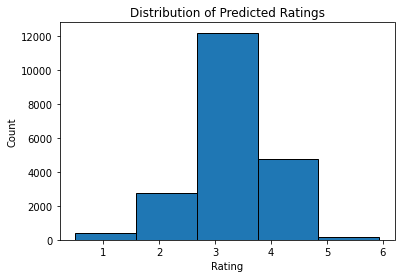

In [46]:
plt.hist(final_results['ratingPred'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Predicted Ratings')
plt.show()
# it appears to be a normal distribution with most ratings centered at 3-4

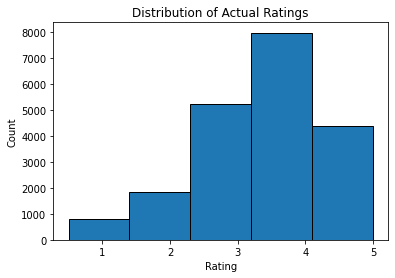

In [47]:
plt.hist(final_results['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Actual Ratings')
plt.show()
# it appears to be a normal distribution with most ratings centered at 3-4

In [48]:
final_results.loc[final_results.userId=='257'].sort_values('ratingPred', ascending=False)[['userId', 'movieId', 'rating', 'ratingPred','roundedRating', 'title', 'genres',
       ]]

,userId,movieId,rating,ratingPred,roundedRating,title,genres
7511,257,2502,1.5,3.749927,4,Office Space (1999),Comedy|Crime
7509,257,1380,4.0,3.602580,4,Grease (1978),Comedy|Musical|Romance
7506,257,7,1.0,3.499733,3.5,Sabrina (1995),Comedy|Romance
7508,257,653,4.0,3.497928,3.5,Dragonheart (1996),Action|Adventure|Fantasy
7512,257,2599,1.5,3.094474,3.5,Election (1999),Comedy
7507,257,16,3.5,2.997004,3,Casino (1995),Crime|Drama
7510,257,2406,3.5,2.502217,3,Romancing the Stone (1984),Action|Adventure|Comedy|Romance


In [49]:
final_results.loc[final_results.userId=='143'].sort_values('ratingPred', ascending=False).shape

(16, 7)

In [50]:
final_results.columns

Index(['userId', 'movieId', 'rating', 'ratingPred', 'title', 'genres',
       'roundedRating'],
      dtype='object')

In [51]:
final_results.loc[final_results.userId=='143'].sort_values('ratingPred', ascending=False)[['userId', 'movieId', 'rating', 'ratingPred','roundedRating', 'title', 'genres',
       ]]

,userId,movieId,rating,ratingPred,roundedRating,title,genres
4372,143,59421,4.0,4.501984,5,What Happens in Vegas... (2008),Comedy|Romance
4373,143,61250,3.5,4.000000,4,"House Bunny, The (2008)",Comedy
4374,143,81847,5.0,4.000000,4,Tangled (2010),Animation|Children|Comedy|Fantasy|Musical|Roma...
4362,143,1307,2.0,3.466824,3.5,When Harry Met Sally... (1989),Comedy|Romance
4365,143,4018,2.0,3.405393,3.5,What Women Want (2000),Comedy|Romance
4367,143,6593,4.0,3.397674,3.5,Freaky Friday (2003),Children|Comedy|Fantasy
4361,143,500,3.0,3.264349,3.5,Mrs. Doubtfire (1993),Comedy|Drama
4368,143,7255,3.0,3.264349,3.5,Win a Date with Tad Hamilton! (2004),Comedy|Romance
4369,143,7293,5.0,3.264349,3.5,50 First Dates (2004),Comedy|Romance
4370,143,7444,5.0,3.264349,3.5,13 Going on 30 (2004),Comedy|Fantasy|Romance


In [52]:
final_results.loc[final_results.userId=='414'].sort_values('ratingPred', ascending=False).head(10)[['userId', 'movieId', 'rating', 'ratingPred','roundedRating', 'title', 'genres',
       ]]

,userId,movieId,rating,ratingPred,roundedRating,title,genres
12603,414,1032,4.0,5.235183,5,Alice in Wonderland (1951),Adventure|Animation|Children|Fantasy|Musical
12709,414,2410,3.0,5.200844,5,Rocky III (1982),Action|Drama
12646,414,1611,3.0,5.068073,5,My Own Private Idaho (1991),Drama|Romance
12687,414,2100,3.0,5.036385,5,Splash (1984),Comedy|Fantasy|Romance
13084,414,162350,2.5,5.033793,5,The Magnificent Seven (2016),Action|Western
12781,414,3765,3.0,5.011974,5,"Hot Spot, The (1990)",Crime|Drama|Romance
12673,414,1991,2.0,5.010334,5,Child's Play (1988),Horror|Thriller
12708,414,2407,4.0,4.995377,5,Cocoon (1985),Comedy|Sci-Fi
12794,414,4019,4.0,4.988248,5,Finding Forrester (2000),Drama
12669,414,1957,3.0,4.984607,5,Chariots of Fire (1981),Drama


# Evaluation

##Calculate RMSE and MAE

In [53]:
print('RMSE custom method:', mean_squared_error(final_results['rating'], final_results['ratingPred']))
print('mean_absolute_error:', mean_absolute_error(final_results['rating'], final_results['ratingPred']))


RMSE custom method: 1.5561244397158023
mean_absolute_error: 0.9944567227502286


In [54]:
print('RMSE custom method:', mean_squared_error(final_results['rating'], final_results['roundedRating']))
print('mean_absolute_error:', mean_absolute_error(final_results['rating'], final_results['roundedRating']))


RMSE custom method: 1.535443069184871
mean_absolute_error: 0.9624981507963903


## Calculate precision@K and recall@k

In [0]:
precisionAndRecall = pd.DataFrame(columns=['userId', 'precision@k', 'recall@k'])

In [0]:
k=10
for user in allUsers:
  x= final_results.loc[final_results.userId==user]
  #x = x.sort_values('rating', ascending=False)
  
  relevantItems = x.loc[x.rating>=3.5].sort_values('rating', ascending=False)
  numRrelevantItems= len(relevantItems)
  
  recommendedItemsAtK = x.loc[x.ratingPred>=3.5].sort_values('ratingPred', ascending=False).head(k)
  numRecommendedItemsAtK = len(recommendedItemsAtK)

  recommendedAndRelevantAtK = pd.merge(relevantItems, recommendedItemsAtK, how='inner').head(k)
  numRecommendedAndRelevantAtK = len(recommendedAndRelevantAtK)

  if(numRecommendedItemsAtK == 0):
    precisionAtK = 1
  else:  
    precisionAtK = numRecommendedAndRelevantAtK/numRecommendedItemsAtK

  if(numRrelevantItems==0):
    recallAtK = 1
  else:  
    recallAtK = numRecommendedAndRelevantAtK/numRrelevantItems

  precisionAndRecall = precisionAndRecall.append({'userId': user, 'precision@k': precisionAtK, 'recall@k': recallAtK},ignore_index=True)

In [57]:
precisionAndRecall

,userId,precision@k,recall@k
0,1,0.900000,0.243243
1,2,1.000000,0.500000
2,3,0.333333,0.250000
3,4,0.900000,0.310345
4,5,0.333333,0.500000
...,...,...,...
604,606,0.900000,0.050562
605,607,0.500000,0.238095
606,608,0.400000,0.056338
607,609,0.400000,0.666667


In [58]:
meanPrecision = precisionAndRecall['precision@k'].mean(axis = 0)
meanRecall = precisionAndRecall['recall@k'].mean(axis = 0)
print('Mean Precision@K=10: ', meanPrecision)
print('Mean Recall@K=10: ', meanRecall)
print('Mean F1@K=10:',((2*meanPrecision*meanRecall)/(meanPrecision+meanRecall)) )

Mean Precision@K=10:  0.6576680480621366
Mean Recall@K=10:  0.33416928262228923
Mean F1@K=10: 0.4431623070143358


## Calculate F1 score

In [0]:
#F1 = 2 * (precision * recall) / (precision + recall)
precisionAndRecall['F1@k']=''

for i, row in precisionAndRecall.iterrows():
  #print(row['precision@k'])
  if(row['precision@k']==0 or row['recall@k'] ==0 ):
    precisionAndRecall.loc[i, 'F1@k'] = 0
    #row['F1@k'] = 0
  else:
    precisionAndRecall.loc[i, 'F1@k'] = (2*row['precision@k']*row['recall@k'])/(row['precision@k']+row['recall@k'])

In [60]:
#user who rated minimum number of time (20 times)
#userId-257
precisionAndRecall.loc[precisionAndRecall.userId=='257']

,userId,precision@k,recall@k,F1@k
255,257,0.5,0.25,0.333333


In [61]:
#user who rated median number of time (71 times)
#userId-143
precisionAndRecall.loc[precisionAndRecall.userId=='143']

,userId,precision@k,recall@k,F1@k
142,143,1.0,0.272727,0.428571


In [62]:
#user who rated maximum number of time (2698 times)
#userId-414
precisionAndRecall.loc[precisionAndRecall.userId=='414']

,userId,precision@k,recall@k,F1@k
412,414,0.3,0.009677,0.01875


# Using Surprise

In [0]:
pip install surprise

In [0]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader


In [0]:
reader = Reader(rating_scale=(0,5))

In [0]:
data_train = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

In [0]:
data_test = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)

In [0]:
cross_validate(SVD(), data_train, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [0]:
from surprise import accuracy

# We'll use the famous SVD algorithm.
algo = SVD()

trainset = data_train.build_full_trainset()
testset = data_test.build_full_trainset().build_testset()
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
accuracy.mae(predictions)

In [0]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [0]:
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])